In [1]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
save_dir1 = "../figures/magnetic_data_EDA/transformed_plots"
os.makedirs(save_dir1, exist_ok=True)

# 2020 Data Analysis

In [3]:
ddf = dd.read_parquet("../data/processed/magnetic_data/train/", engine = "pyarrow")
print("--- Loaded the PROCESSED dataset ---")

--- Loaded the PROCESSED dataset ---


In [4]:
print("Verifying DataFrame structure and column types:")
print(ddf.info())
print("\n------------------------------------------\n")
print("Verifying descriptive statistics of the final features:")
print(ddf.describe().compute())

Verifying DataFrame structure and column types:
<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 10 entries, record_id to R_VALUE
dtypes: float64(7), int64(2), string(1)None

------------------------------------------

Verifying descriptive statistics of the final features:
          record_id        seq_id    USFLUX_log    TOTPOT_log   PIL_LEN_log  \
count  1.278372e+07  1.278372e+07  1.278372e+07  1.278372e+07  1.278372e+07   
mean   9.135071e+04  4.147623e+01  4.877810e+01  5.049169e+01  2.294298e+00   
std    4.607582e+04  2.958142e+01  4.354667e+00  4.720633e+00  2.536081e+00   
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.287800e+04  2.900000e+01  4.790483e+01  4.920593e+01  0.000000e+00   
50%    9.989750e+04  4.425000e+01  4.922973e+01  5.067734e+01  1.791759e+00   
75%    1.268110e+05  5.900000e+01  5.063329e+01  5.295987e+01  4.624973e+00   
max    1.710370e+05  1.190000e+02  5.322033e+01  6.202874e+01  1.016950e+01   

        

## Scale
Looking at the mean and std (standard deviation) values across different columns such as
- TOTPOT has a mean in the order of 10^23.
- SAVNCPP has a mean in the order of 10^12.
- EPSZ has a mean of approximately -0.5.
- FDIM has a mean close to zero.

This vast difference in scales is a strong indicator that we need to perform feature scaling (like Standardization or Normalization) before implementing most machine learning models (especially distance-based algorithms like SVM or algorithms that use gradient descent like neural networks).

## Skewedness
Note that for many features, the mean is significantly different from the median (the 50% mark). As we can see for TOTUSJH, the mean is ~471, while the 50th percentile (median) is ~155. The mean is pulled higher than the median, which suggests a right-skewed distribution and this is further confirmed by the 75th percentile being ~727, while the maximum value is a much larger 11,523.

For features with such high skewness, we might need to apply transformations to make their distributions more symmetrical such as
- Logarithmic transformation: `np.log1p(x)` (useful for right-skewed data and handles zero values).
- Square root transformation: `np.sqrt(x)`.
- Box-Cox transformation.

## Zero Inflation
For features like FDIM, BZ_FDIM, BT_FDIM, and BP_FDIM. The 25th, 50th, and 75th percentiles are all 0. The mean is very close to zero, but the maximum value is non-zero (though small). This suggests that a very large proportion of the values for these features are zero. This needs further investigation if these features provide any meaningful signal or if they are mostly noise, in which case it is better to remove them

# Distribution Visualization

In [5]:
numeric_ddf = ddf.select_dtypes(include = ['float64'])

In [6]:
sample_df = numeric_ddf.sample(frac=0.01).compute()

In [7]:
quantiles = numeric_ddf.quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]).compute()



------------- Verifying Distribution for USFLUX_log -------------

Quantiles for USFLUX_log:
0.00     0.000000
0.25    47.886546
0.50    49.199558
0.75    50.594017
0.90    51.458847
0.95    51.930742
0.99    52.552642
1.00    53.220333
Name: USFLUX_log, dtype: float64


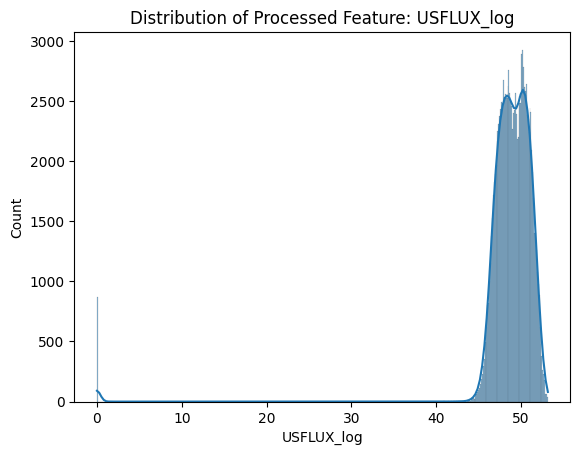



------------- Verifying Distribution for TOTPOT_log -------------

Quantiles for TOTPOT_log:
0.00     0.000000
0.25    49.185501
0.50    50.630290
0.75    52.895312
0.90    54.185579
0.95    54.655107
0.99    55.658821
1.00    62.028737
Name: TOTPOT_log, dtype: float64


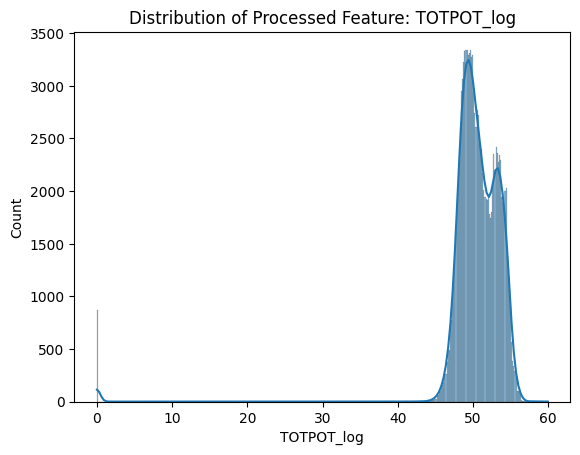



------------- Verifying Distribution for PIL_LEN_log -------------

Quantiles for PIL_LEN_log:
0.00     0.000000
0.25     0.000000
0.50     1.609438
0.75     4.532599
0.90     6.324359
0.95     7.182352
0.99     8.473450
1.00    10.169499
Name: PIL_LEN_log, dtype: float64


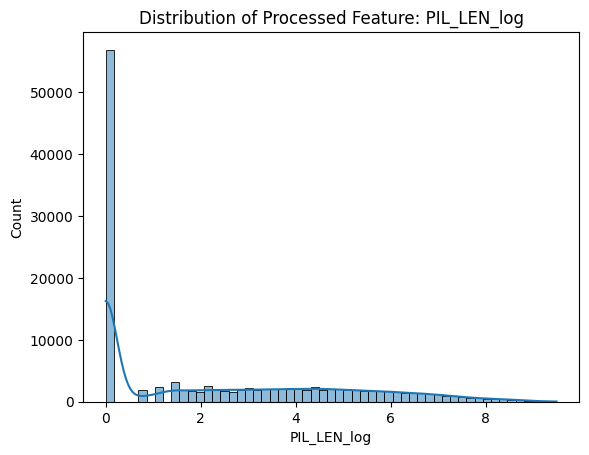



------------- Verifying Distribution for MEANSHR -------------

Quantiles for MEANSHR:
0.00      0.000000
0.25     21.874546
0.50     23.887186
0.75     31.628656
0.90     40.260515
0.95     44.451527
0.99     52.233714
1.00    135.784277
Name: MEANSHR, dtype: float64


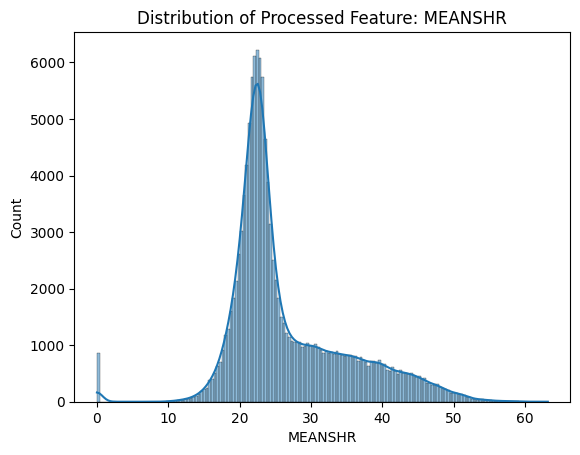



------------- Verifying Distribution for TOTFZ -------------

Quantiles for TOTFZ:
0.00   -5.264704e+25
0.25   -2.636853e+24
0.50   -7.936863e+23
0.75   -1.967109e+23
0.90   -6.961123e+22
0.95   -4.026615e+22
0.99    0.000000e+00
1.00    3.770667e+24
Name: TOTFZ, dtype: float64


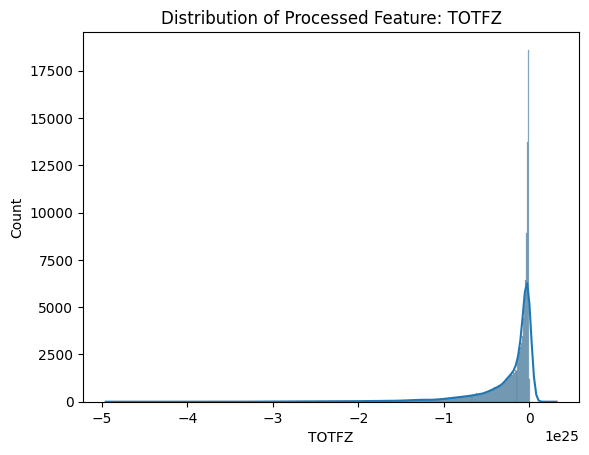



------------- Verifying Distribution for EPSZ -------------

Quantiles for EPSZ:
0.00   -0.990590
0.25   -0.630160
0.50   -0.568846
0.75   -0.376099
0.90   -0.205171
0.95   -0.138075
0.99    0.000000
1.00    0.999210
Name: EPSZ, dtype: float64


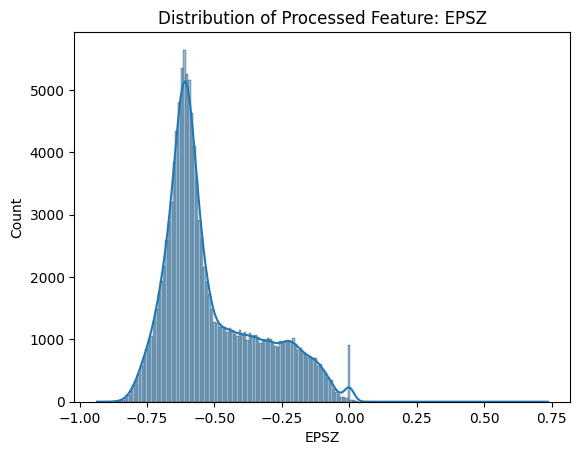



------------- Verifying Distribution for R_VALUE -------------

Quantiles for R_VALUE:
0.00    0.000000
0.25    0.000000
0.50    0.000000
0.75    3.644230
0.90    4.396197
0.95    4.719149
0.99    5.200704
1.00    5.838592
Name: R_VALUE, dtype: float64


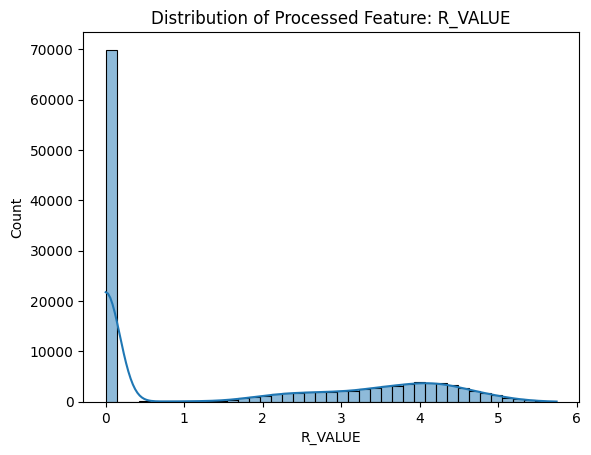

In [8]:
for feature in numeric_ddf.columns:
    print(f"\n\n------------- Verifying Distribution for {feature} -------------\n")
    print(f"Quantiles for {feature}:\n{quantiles[feature]}")
    sns.histplot(data=sample_df, x=feature, kde=True)
    plt.title(f"Distribution of Processed Feature: {feature}")
    save_path = os.path.join(save_dir1, f"{feature}_distribution.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

## Heavily Right-Skewed Features
- Features: TOTUSJH, TOTBSQ, TOTPOT, TOTUSJZ, ABSNJZH, SAVNCPP, USFLUX, PIL_LEN, MEANPOT.
- The median (50%) is tiny compared to the maximum (100%). Most of the data is clustered near zero, with a long tail of extremely large values. These large values are probably the most interesting ones (related to large flares).
- Such highly right skewed features are the top candidates for **Logathmic Transformation", as it compresses the large values and spreads out the smaller ones,  making the distribution more symmetrical and a symmetrical distribution is often easier for models to learn from.

## Zero Inflated Features
- Features: FDIM, BZ_FDIM, BT_FDIM, BP_FDIM, and R_VALUE.
- The 75th percentile (and sometimes even the 99th!) is zero. This means the vast majority of observations for these features are zero.
- These features might have low predictive power, but the rare non-zero values could be significant. For now, we will keep them. They do not need a log transform, but they will need scaling.

## Left-Skewed or Symmetric around Zero
- Features: TOTFZ, TOTFY, TOTFX, MEANJZH, MEANJZD.
- These distributions have significant negative values. TOTFZ is a great example of a left skew, where the 99th percentile is 0, but the minimum is a large negative number.
- But note that we should not apply log transformation to these, as log is not defined for -ve values. These are best handled by scaling.

# Class Imbalence


--- Verifying Class Distribution ---

Class Distribution:
 label
C     1261440
Q    10554840
B      712560
X       23100
M      231780
Name: count, dtype: int64[pyarrow]


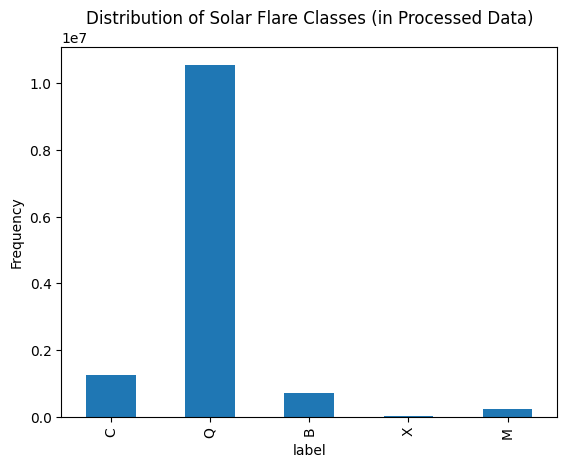

In [9]:
print("\n--- Verifying Class Distribution ---\n")
class_dist = ddf["label"].value_counts().compute()
print("Class Distribution:\n", class_dist)

class_dist.plot(kind = "bar")
plt.title("Distribution of Solar Flare Classes (in Processed Data)")
plt.ylabel("Frequency")
save_path = os.path.join(save_dir1, "class_distribution.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Correlational Analysis


--- Verifying Correlation Matrix ---



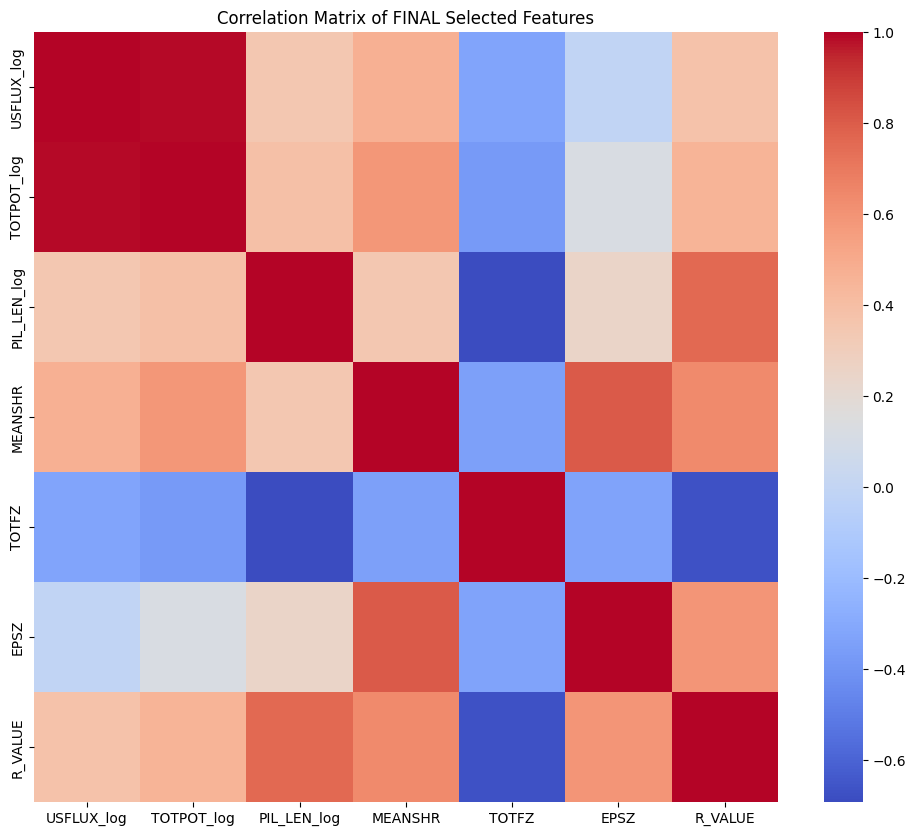

In [10]:
print("\n--- Verifying Correlation Matrix ---\n")
correlation_matrix = numeric_ddf.corr().compute()
plt.figure(figsize = (12,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of FINAL Selected Features")
save_path = os.path.join(save_dir1, "correlation_matrix.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

## Postively Correlated Features
Looking at the top-left corner of the matrix. There is a large, dark red square spanning from TOTUSJH to USFLUX, which tells us that they are extremely highly correlated with each other. As are all different ways of measuring the overall size and energy of the active region. When one is high, the others are almost always high too. Hence, including all of these features in a model is redundant. It's like telling the model the same thing in six different ways. This can make the model harder to interpret and can destabilize some algorithms.

There's another distinct red block of correlations around MEANSHR, MEANGAM, MEANGBT, MEANGBZ, and MEANGBH. These variables, which likely represent the average shear, gradient, and magnetic field components, are also highly correlated among themselves.They collectively describe the magnetic field's complexity and stress level. Hence, similar to the first cluster, we don't likely need all of these.

And lastly the features R_VALUE, RBZ_VALUE, RBT_VALUE, and RBP_VALUE show a strong positive correlation with each other. This is expected as they are related calculations.

## Negatively Correlated Features
Notice the blue squares around "Energy/Flux" cluster. For example, TOTFZ has a negative correlation with the "Energy/Flux" cluster. This is physically meaningful and represents a relationship between the vertical component of the magnetic field and the overall energy.